In [1]:
# mount drive in colab
from google.colab import drive
drive.mount('/content/drive')

# assert torch cuda
import torch
torch.cuda.is_available()

Mounted at /content/drive


True

In [5]:
import os
import json
import tqdm

import numpy as np
import pandas as pd

IMAGES_FOLDER = '/content/drive/MyDrive/Colab Notebooks/data/images'
DATA_FOLDER = '/content/drive/MyDrive/Colab Notebooks/data/json'

def load_data(json_data_dir=DATA_FOLDER):

    # check the path to data exists
    assert os.path.exists(json_data_dir) and os.path.isdir(json_data_dir)

    # load data
    registered_data = {}
    for json_path in tqdm.tqdm(sorted(os.listdir(json_data_dir))):
        json_path = os.path.join(json_data_dir, json_path)
        json_data = {}
        with open(json_path, 'r') as f:
            json_data = json.load(f)

        # check the keys of the loaded data
        assert [key in json_data.keys() for key in ['pose3d', 'rot4d', 'image_path']]

        registered_data[json_path] = json_data.copy()
    return registered_data

# load locally
json_data = load_data()
len(json_data)

100%|██████████| 13/13 [00:03<00:00,  3.66it/s]


13

/content/drive/MyDrive/Colab Notebooks/data/images/camera_img_250720093929.jpg


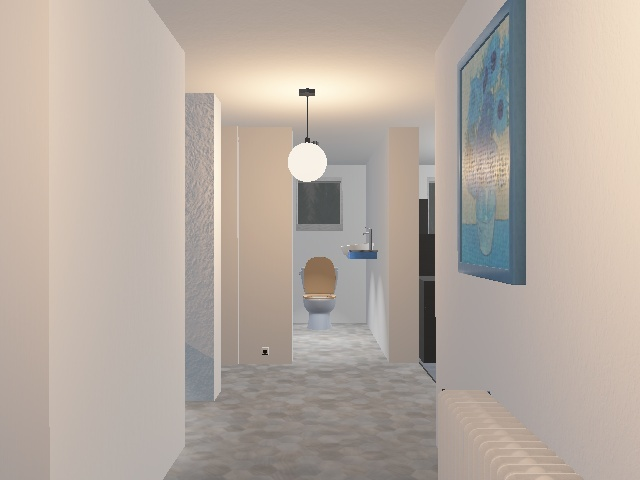

In [6]:
import cv2
from google.colab.patches import cv2_imshow

# update the image path in data from local to
def add_colab_image_path_to_data(json_data):
  for json_path, data in json_data.items():
    local_image_path = data['local_image_path']
    data['colab_image_path'] = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/images', os.path.basename(local_image_path))
  return json_data

json_data = add_colab_image_path_to_data(json_data)
rd_img_path = list(json_data.values())[0]['colab_image_path']
print(rd_img_path)

img = cv2.imread(rd_img_path)
cv2_imshow(img)

In [7]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

# load model locally
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Salesforce/blip2-opt-2.7b"

model = Blip2ForConditionalGeneration.from_pretrained(model_name, torch_dtype=torch.float16)
model.to(DEVICE)
processor = AutoProcessor.from_pretrained(model_name)


def query_blip2(image, prompts=[], model=model, processor=processor, device=DEVICE):
  outputs = []

  # image captioning: global answer
  inputs = processor(image, return_tensors="pt").to(device, torch.float16)
  generated_ids = model.generate(**inputs, max_new_tokens=20)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  outputs.append(generated_text)

  # prompted image captioning(s)
  for prompt in prompts:
    inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    outputs.append(generated_text)

  return outputs # len = 1 (global) +1 for prompt in prompts

rd_blip_output = query_blip2(img)
rd_blip_output

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

['a rendering of a hallway with a toilet and a painting']

In [8]:
blip_prompts = ["Question: I'm in a house. In what place am I? Answer:"]
for json_path, data in tqdm.tqdm(json_data.items()):
  image = cv2.imread(data['colab_image_path'])
  blip_output = query_blip2(image, prompts=blip_prompts)
  print(blip_output)
  json_data[json_path]['blip'] = blip_output

list(json_data.values())[0]

  8%|▊         | 1/13 [00:00<00:07,  1.53it/s]

['a rendering of a hallway with a toilet and a painting', "Question: I'm in a house. In what place am I? Answer: In the hallway."]


 15%|█▌        | 2/13 [00:01<00:10,  1.08it/s]

['a rendering of a hallway with a door and a fire extinguisher', "Question: I'm in a house. In what place am I? Answer: In the kitchen."]


 23%|██▎       | 3/13 [00:02<00:09,  1.07it/s]

['a 3d rendering of a bedroom with a bed and lamp', "Question: I'm in a house. In what place am I? Answer: In the bedroom."]


 31%|███       | 4/13 [00:03<00:08,  1.03it/s]

['a 3d rendering of a bathroom with a sink and toilet', "Question: I'm in a house. In what place am I? Answer: In the bathroom."]


 38%|███▊      | 5/13 [00:04<00:07,  1.08it/s]

['a 3d rendering of a bathroom with a toilet and sink', "Question: I'm in a house. In what place am I? Answer: In the bathroom."]


 46%|████▌     | 6/13 [00:05<00:06,  1.13it/s]

['a 3d rendering of a bathroom with a toilet and bed', "Question: I'm in a house. In what place am I? Answer: In the bathroom."]


 54%|█████▍    | 7/13 [00:06<00:05,  1.15it/s]

['a 3d rendering of a bedroom with a bed and desk', "Question: I'm in a house. In what place am I? Answer: In the bedroom."]


 62%|██████▏   | 8/13 [00:06<00:04,  1.21it/s]

['a small bathroom with a toilet and sink', "Question: I'm in a house. In what place am I? Answer: In the bathroom."]


 69%|██████▉   | 9/13 [00:07<00:03,  1.18it/s]

['a 3d rendering of a living room with black furniture', "Question: I'm in a house. In what place am I? Answer: In the living room."]


 77%|███████▋  | 10/13 [00:08<00:02,  1.15it/s]

['a 3d rendering of a living room with a tv and a table', "Question: I'm in a house. In what place am I? Answer: In the living room."]


 85%|████████▍ | 11/13 [00:09<00:01,  1.15it/s]

['a 3d rendering of a dining room with a table and chairs', "Question: I'm in a house. In what place am I? Answer: In the kitchen."]


 92%|█████████▏| 12/13 [00:10<00:00,  1.21it/s]

['a kitchen with a red refrigerator and a table', "Question: I'm in a house. In what place am I? Answer: In the kitchen."]


100%|██████████| 13/13 [00:11<00:00,  1.17it/s]

['a 3d rendering of a dining room and kitchen', "Question: I'm in a house. In what place am I? Answer: In the kitchen."]


{'pose3d': [-0.87, -7.46, 1.25],
 'rot4d': [0.7071067811865475, 0.0, 0.7071067811865475, 3.14],
 'local_image_path': '/home/hostuser/workspace/colcon_ws/src/flying_camera/data/images/camera_img_250720093929.jpg',
 'colab_image_path': '/content/drive/MyDrive/Colab Notebooks/data/images/camera_img_250720093929.jpg',
 'blip': ['a rendering of a hallway with a toilet and a painting',
  "Question: I'm in a house. In what place am I? Answer: In the hallway."]}

In [9]:
import time

for colab_json_path in json_data.keys():

  # assert updates
  assert json_data[colab_json_path]['local_image_path']
  assert 'blip' in json_data[colab_json_path]

  # write data updates
  data = json_data[colab_json_path]
  with open(colab_json_path, 'w') as f:
    json.dump(data, f, indent=4)

  time.sleep(.05)

  # test
  with open(colab_json_path, 'r') as f:
    assert data == json.load(f)

with open(list(json_data.keys())[0], 'r') as f:
  print(json.load(f))

{'pose3d': [-0.87, -7.46, 1.25], 'rot4d': [0.7071067811865475, 0.0, 0.7071067811865475, 3.14], 'local_image_path': '/home/hostuser/workspace/colcon_ws/src/flying_camera/data/images/camera_img_250720093929.jpg', 'colab_image_path': '/content/drive/MyDrive/Colab Notebooks/data/images/camera_img_250720093929.jpg', 'blip': ['a rendering of a hallway with a toilet and a painting', "Question: I'm in a house. In what place am I? Answer: In the hallway."]}
